In [4]:
from simulation import build_hamiltonian, cut_circuit, run_exact_sampler, run_mps_simulator_knitted, run_mps_simulator_full, run_statevector_simulator_full, reconstruct_expectation, trotterization_circuit
from utils import circuit_data_dict, save_to_json

from qiskit.transpiler import CouplingMap
from qiskit.quantum_info import SparsePauliOp
import numpy as np
import matplotlib.pyplot as plt
import string
import networkx as nx
from qiskit_aer.primitives import EstimatorV2
import random

FIRST THE FULL SIMULATION (NO KNITTING) TO BE SIMULATED WITH MPS AND ESTIMATOR

=== Configuration ===
Number of Spins per Ring: 5
Number of Rings: 2
Anisotropy (J): 0.98
External Magnetic Field (H): 2.0
Two-Qubit Gates: ['ZZ']
Single-Qubit Gates: ['X']
Trotter Repetitions: 1000
Time Parameter (dt): 0.01
Decreasing J Flag: False
Number of circuit samples: inf
Number of shots (tensor simulation): 100
=== Coupling Map === 


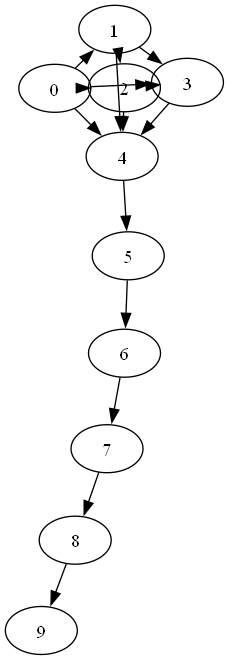

Obtained full circuit
Run tensor simulation:  0.011736804784730196
Subcircuits data has been successfully saved to 'subcircuits.json'.


In [ ]:
def main(config):
    config.display_configuration()
    # Define Copling map for qubits and total number of qubits
    num_qubits = config.NUM_RINGS * config.NUM_SPINS
    edges = config.EDGES
    coupling_map = CouplingMap(edges)

    print("=== Coupling Map === ")
    display(coupling_map.draw())
    # Better-looking coupling map plot (maybe for report)
    # plot_coupling_map(coupling_map, config.NUM_RINGS, config.NUM_SPINS)
    
    # Build Hamiltonian
    H = build_hamiltonian(
        num_qubits=num_qubits,
        coupling_map=coupling_map,
        decrease=config.DECREASING,
        single_gates=config.SINGLE_GATES_LIST,
        two_gates=config.TWO_GATES_LIST,
        anisotropy=config.ANISOTROPY,
        h=config.H_FIELD
    )

    #Obtain evolution circuit under TrotterLie approximation
    evolutionQC = trotterization_circuit(hamiltonian = H, trotter_reps = config.TROTTER_REPS, dt = config.DT) #Try option preserve_order
    # display(evolutionQC.draw('mpl', fold = False))
    print('Obtained full circuit')
    # Define observables (Z on each site, ZII + IZI + IIZ)
    z_list = [('Z', [i], 1.0) for i in range(num_qubits)]
    # Define observable (ZZZZ)
    # z_list = [(num_qubits*'Z', np.arange(num_qubits), 1.0)]
    z_observables = SparsePauliOp.from_sparse_list(z_list, num_qubits=num_qubits)

    # Run Simulations

    results_tensor = run_mps_simulator_full(circuit=evolutionQC, observables=z_observables, shots = config.SHOTS_TENSOR) #Beyond 21 qubits I run into memory errors
    print('Run tensor simulation: ', results_tensor)
    # results_statevector = run_statevector_simulator_full(circuit=evolutionQC, observables=z_observables)
    # print('Run statevector simulation: ', results_statevector)


    # Generate experiment and subcircuit data dictionary, and save to JSON
    basis_gates = ["h", "rx", "ry", "rz", "rxx", "rzz", "ryy", "cx"]
    experiment = {"A": [evolutionQC]}
    coefficients = [(1,0)]
    data_dict = circuit_data_dict(experiment, coefficients, float(results_tensor), basis_gates)
    save_to_json(data_dict)
    
class Config:
    """
    Configuration parameters for the quantum simulation.
    """
    def __init__(self, num_spins=3, num_rings=3, anisotropy=0.98, h_field=2.0,
                 two_gates_list=['ZZ'], single_gates_list=['X'],
                 trotter_reps=1, dt=0.1, decreasing=False, n_samples=np.inf, 
                 edge_probability = 0.5, shots_tensor = 100, model = "ring"):
        """
        Initializes the configuration with given parameters.

        Parameters:
        - num_spins (int): Number of qubits per ring.
        - num_rings (int): Total number of rings.
        - anisotropy (float): Variable J in the Hamiltonian.
        - h_field (float): External magnetic field.
        - two_gates_list (list): List of two-qubit gates in the Hamiltonian.
        - single_gates_list (list): List of single-qubit gates in the Hamiltonian.
        - trotter_reps (int): Number of Trotter repetitions.
        - dt (float): Time parameter.
        - decreasing (bool): Flag for decreasing the intensity of J with distance to the first qubit.
        - n_samples (int or float): Number of samples for generation of knitting subexperiments.
        - model (string): allows to choose between the different hamiltonian models.
        """
        self.NUM_SPINS = num_spins 
        self.NUM_RINGS = num_rings
        self.ANISOTROPY = anisotropy
        self.H_FIELD = h_field

        self.TWO_GATES_LIST = two_gates_list
        self.SINGLE_GATES_LIST = single_gates_list

        if model == "ring":
            self._build_ring_model()

        elif model == "line":
            self.NUM_RINGS = 1
            self._build_line_model()

        elif model == "impurity":
            # Later I will give the model more configurability. For now, size of bath is the same as size of "impurity". 
            # For ease of use we use 2 "rings". The first one will be the impurity and second will be the bath
            self.NUM_RINGS = 2
            self.EDGE_PROB = edge_probability
            random.seed(1)
            self._build_impurity_model()
        else:
            raise ValueError(f"'{model}' is not a valid model. Choose from: 'ring', 'line'. 'impurity'.")
        
        self.TROTTER_REPS = trotter_reps
        self.DT = dt  

        self.DECREASING = decreasing  # Mostly for use with the line model.

        self.N_SAMPLES = n_samples
        self.SHOTS_TENSOR = shots_tensor

    def _get_qubit_index(self, ring, qubit):
        return ring * self.NUM_SPINS + qubit

    def _generate_inter_ring_edges(self):
        """
        Generates inter-ring connections to connect each ring to its next ring
        """
        inter_edges = []

        if self.NUM_RINGS == 1:
            return inter_edges
        if self.NUM_RINGS == 2:
            current_qubit = self._get_qubit_index(0, 0)  # First qubit of the first ring
            next_qubit = self._get_qubit_index(1, self.NUM_SPINS - 1)  # Last qubit of the second ring
            inter_edges.append((current_qubit, next_qubit))
        else:
            for ring in range(self.NUM_RINGS):
                next_ring = (ring + 1) % self.NUM_RINGS
                current_qubit = self._get_qubit_index(ring, 0)  # First qubit of the current ring
                next_qubit = self._get_qubit_index(next_ring, self.NUM_SPINS - 1)  # Last qubit of the next ring
                inter_edges.append((current_qubit, next_qubit))
        return inter_edges
    
    def _build_ring_model(self):
        self.intra_edges = [
            (self._get_qubit_index(ring, i),
            self._get_qubit_index(ring, (i + 1) % self.NUM_SPINS))
            for ring in range(self.NUM_RINGS)
            for i in range(self.NUM_SPINS)
        ]
        self.inter_edges = self._generate_inter_ring_edges()
        self.EDGES = self.intra_edges + self.inter_edges

    def _build_line_model(self):
        self.EDGES = [(i, i + 1) for i in range(self.NUM_SPINS - 1)]
        

    def _build_impurity_model(self):
        """
        Builds the impurity model consisting of two regions:
        1. Impurity Region: Randomly connected edges within the first NUM_SPINS qubits.
        2. Bath Region: Linearly connected edges within the next NUM_SPINS qubits.
        """
        total_qubits = self.NUM_RINGS * self.NUM_SPINS

        if self.NUM_RINGS != 2:
            raise ValueError("Impurity model currently supports exactly 2 rings.")

        # Impurity region
        impurity_ring = 0  # First ring
        impurity_qubits = [self._get_qubit_index(impurity_ring, q) for q in range(self.NUM_SPINS)]
        self.impurity_edges = []

        # Generate random edges within the impurity region
        
        
        for i in range(self.NUM_SPINS):
            for j in range(i + 1, self.NUM_SPINS):
                if random.random() < self.EDGE_PROB:
                    edge = (impurity_qubits[i], impurity_qubits[j])
                    self.impurity_edges.append(edge)

        # ----- Bath Region -----
        bath_ring = 1  # Second ring
        bath_qubits = [self._get_qubit_index(bath_ring, q) for q in range(self.NUM_SPINS)]
        self.bath_edges = [(bath_qubits[i],bath_qubits[i+1]) for i in range(len(bath_qubits)-1)]
        # ----- Inter-Ring Connections -----
        self.inter_edges = [(impurity_qubits[-1], bath_qubits[0])]

        # ----- Combine All Edges -----
        self.EDGES = self.impurity_edges + self.bath_edges + self.inter_edges


    def display_configuration(self):
        """
        Prints the current configuration for verification.
        """
        print("=== Configuration ===")
        print(f"Number of Spins per Ring: {self.NUM_SPINS}")
        print(f"Number of Rings: {self.NUM_RINGS}")
        print(f"Anisotropy (J): {self.ANISOTROPY}")
        print(f"External Magnetic Field (H): {self.H_FIELD}")
        print(f"Two-Qubit Gates: {self.TWO_GATES_LIST}")
        print(f"Single-Qubit Gates: {self.SINGLE_GATES_LIST}")
        print(f"Trotter Repetitions: {self.TROTTER_REPS}")
        print(f"Time Parameter (dt): {self.DT}")
        print(f"Decreasing J Flag: {self.DECREASING}")
        print(f"Number of circuit samples: {self.N_SAMPLES}")
        print(f"Number of shots (tensor simulation): {self.SHOTS_TENSOR}")
        print("=====================")

if __name__ == "__main__":
    
    config = Config(num_spins=5, num_rings=3, dt = 0.01, trotter_reps = 1000, shots_tensor = 100,  #What does the number of shots mean in this tensor simulation?
                    model = "impurity", edge_probability=1, decreasing = False) 

    main(config)


=== Configuration ===
Number of Spins per Ring: 5
Number of Rings: 2
Anisotropy (J): 0.98
External Magnetic Field (H): 1.0
Two-Qubit Gates: ['XX']
Single-Qubit Gates: ['Z']
Trotter Repetitions: 1
Time Parameter (dt): 0.1
Decreasing J Flag: False
Number of circuit samples: inf
Number of shots (tensor simulation): 100
=== Coupling Map === 


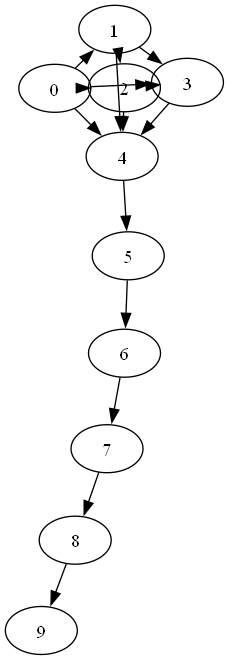

Obtained full circuit
Result_knitting: 9.439351577945628


In [6]:
def main(config):
    config.display_configuration()
    # Define Copling map for qubits and total number of qubits
    num_qubits = config.NUM_RINGS * config.NUM_SPINS
    edges = config.EDGES
    coupling_map = CouplingMap(edges)

    print("=== Coupling Map === ")
    display(coupling_map.draw())
    # Better-looking coupling map plot (maybe for report)
    # plot_coupling_map(coupling_map, config.NUM_RINGS, config.NUM_SPINS)
    
    # Build Hamiltonian
    H = build_hamiltonian(
        num_qubits=num_qubits,
        coupling_map=coupling_map,
        decrease=config.DECREASING,
        single_gates=config.SINGLE_GATES_LIST,
        two_gates=config.TWO_GATES_LIST,
        anisotropy=config.ANISOTROPY,
        h=config.H_FIELD
    )

    #Obtain evolution circuit under TrotterLie approximation
    evolutionQC = trotterization_circuit(hamiltonian = H, trotter_reps = config.TROTTER_REPS, dt = config.DT)
    print('Obtained full circuit')
    # Define observables (Z on each site, ZII + IZI + IIZ)
    z_list = [('Z', [i], 1.0) for i in range(num_qubits)]
    # Define observable (ZZZZ)
    # z_list = [(num_qubits*'Z', np.arange(num_qubits), 1.0)]
    z_observables = SparsePauliOp.from_sparse_list(z_list, num_qubits=num_qubits)


    # Cut circuit and generate subexperiments
    cutting_labels = ''.join([letter * config.NUM_SPINS for letter in string.ascii_uppercase[:config.NUM_RINGS]])
    
    subexperiments, coefficients, subobservables = cut_circuit(
        circuit=evolutionQC,
        partition_labels=cutting_labels,
        observables=z_observables,
        num_samples=config.N_SAMPLES
    )
    
    # Run Simulations

    
    # results_tensor = run_mps_simulator(subexperiments,subobservables,coefficients, config.SHOTS_TENSOR)
    
    # print('Run tensor simulation: ', results_tensor)

    results = run_exact_sampler(subexperiments)

    # # # print(results)
    # # # # print(results['A'])
    # # print('Run simulations')
    # # # Reconstruct Expectation Values
    reconstructed_expval = reconstruct_expectation(
        results, coefficients, subobservables, z_observables
    )
    # # reconstructed_expval = 0
    print('Result_knitting:', np.real(reconstructed_expval))
    # # Generate experiment and subcircuit data dictionary, and save to JSON
    # basis_gates = ["h", "rx", "ry", "rz", "rxx", "rzz", "ryy", "cx"]
    # data_dict = circuit_data_dict(subexperiments, coefficients, reconstructed_expval, basis_gates)
    # save_to_json(data_dict)

    # For bigger simulations
    # basis_gates = ["h", "rx", "ry", "rz", "rxx", "rzz", "ryy", "cx"]
    # data_dict = circuit_data_dict(subexperiments, coefficients, results_tensor, basis_gates)
    # save_to_json(data_dict)
    
class Config:
    """
    Configuration parameters for the quantum simulation.
    """
    def __init__(self, num_spins=3, num_rings=3, anisotropy=0.98, h_field=1.0,
                 two_gates_list=['XX'], single_gates_list=['Z'],
                 trotter_reps=1, dt=0.1, decreasing=False, n_samples=np.inf, 
                 edge_probability = 0.5, shots_tensor = 100, model = "ring"):
        """
        Initializes the configuration with given parameters.

        Parameters:
        - num_spins (int): Number of qubits per ring.
        - num_rings (int): Total number of rings.
        - anisotropy (float): Variable J in the Hamiltonian.
        - h_field (float): External magnetic field.
        - two_gates_list (list): List of two-qubit gates in the Hamiltonian.
        - single_gates_list (list): List of single-qubit gates in the Hamiltonian.
        - trotter_reps (int): Number of Trotter repetitions.
        - dt (float): Time parameter.
        - decreasing (bool): Flag for decreasing the intensity of J with distance to the first qubit.
        - n_samples (int or float): Number of samples for generation of knitting subexperiments.
        - model (string): allows to choose between the different hamiltonian models.
        """
        self.NUM_SPINS = num_spins 
        self.NUM_RINGS = num_rings
        self.ANISOTROPY = anisotropy
        self.H_FIELD = h_field

        self.TWO_GATES_LIST = two_gates_list
        self.SINGLE_GATES_LIST = single_gates_list

        if model == "ring":
            self._build_ring_model()

        elif model == "line":
            self.NUM_RINGS = 1
            self._build_line_model()

        elif model == "impurity":
            # Later I will give the model more configurability. For now, size of bath is the same as size of "impurity". 
            # For ease of use we use 2 "rings". The first one will be the impurity and second will be the bath
            self.NUM_RINGS = 2
            self.EDGE_PROB = edge_probability
            random.seed(1)
            self._build_impurity_model()
        else:
            raise ValueError(f"'{model}' is not a valid model. Choose from: 'ring', 'line'. 'impurity'.")
        
        self.TROTTER_REPS = trotter_reps
        self.DT = dt  

        self.DECREASING = decreasing  # Mostly for use with the line model.

        self.N_SAMPLES = n_samples
        self.SHOTS_TENSOR = shots_tensor

    def _get_qubit_index(self, ring, qubit):
        return ring * self.NUM_SPINS + qubit

    def _generate_inter_ring_edges(self):
        """
        Generates inter-ring connections to connect each ring to its next ring
        """
        inter_edges = []

        if self.NUM_RINGS == 1:
            return inter_edges
        if self.NUM_RINGS == 2:
            current_qubit = self._get_qubit_index(0, 0)  # First qubit of the first ring
            next_qubit = self._get_qubit_index(1, self.NUM_SPINS - 1)  # Last qubit of the second ring
            inter_edges.append((current_qubit, next_qubit))
        else:
            for ring in range(self.NUM_RINGS):
                next_ring = (ring + 1) % self.NUM_RINGS
                current_qubit = self._get_qubit_index(ring, 0)  # First qubit of the current ring
                next_qubit = self._get_qubit_index(next_ring, self.NUM_SPINS - 1)  # Last qubit of the next ring
                inter_edges.append((current_qubit, next_qubit))
        return inter_edges
    
    def _build_ring_model(self):
        self.intra_edges = [
            (self._get_qubit_index(ring, i),
            self._get_qubit_index(ring, (i + 1) % self.NUM_SPINS))
            for ring in range(self.NUM_RINGS)
            for i in range(self.NUM_SPINS)
        ]
        self.inter_edges = self._generate_inter_ring_edges()
        self.EDGES = self.intra_edges + self.inter_edges

    def _build_line_model(self):
        self.EDGES = [(i, i + 1) for i in range(self.NUM_SPINS - 1)]
        

    def _build_impurity_model(self):
        """
        Builds the impurity model consisting of two regions:
        1. Impurity Region: Randomly connected edges within the first NUM_SPINS qubits.
        2. Bath Region: Linearly connected edges within the next NUM_SPINS qubits.
        """
        total_qubits = self.NUM_RINGS * self.NUM_SPINS

        if self.NUM_RINGS != 2:
            raise ValueError("Impurity model currently supports exactly 2 rings.")

        # Impurity region
        impurity_ring = 0  # First ring
        impurity_qubits = [self._get_qubit_index(impurity_ring, q) for q in range(self.NUM_SPINS)]
        self.impurity_edges = []

        # Generate random edges within the impurity region
        
        
        for i in range(self.NUM_SPINS):
            for j in range(i + 1, self.NUM_SPINS):
                if random.random() < self.EDGE_PROB:
                    edge = (impurity_qubits[i], impurity_qubits[j])
                    self.impurity_edges.append(edge)

        # ----- Bath Region -----
        bath_ring = 1  # Second ring
        bath_qubits = [self._get_qubit_index(bath_ring, q) for q in range(self.NUM_SPINS)]
        self.bath_edges = [(bath_qubits[i],bath_qubits[i+1]) for i in range(len(bath_qubits)-1)]
        # ----- Inter-Ring Connections -----
        self.inter_edges = [(impurity_qubits[-1], bath_qubits[0])]

        # ----- Combine All Edges -----
        self.EDGES = self.impurity_edges + self.bath_edges + self.inter_edges


    def display_configuration(self):
        """
        Prints the current configuration for verification.
        """
        print("=== Configuration ===")
        print(f"Number of Spins per Ring: {self.NUM_SPINS}")
        print(f"Number of Rings: {self.NUM_RINGS}")
        print(f"Anisotropy (J): {self.ANISOTROPY}")
        print(f"External Magnetic Field (H): {self.H_FIELD}")
        print(f"Two-Qubit Gates: {self.TWO_GATES_LIST}")
        print(f"Single-Qubit Gates: {self.SINGLE_GATES_LIST}")
        print(f"Trotter Repetitions: {self.TROTTER_REPS}")
        print(f"Time Parameter (dt): {self.DT}")
        print(f"Decreasing J Flag: {self.DECREASING}")
        print(f"Number of circuit samples: {self.N_SAMPLES}")
        print(f"Number of shots (tensor simulation): {self.SHOTS_TENSOR}")
        print("=====================")

if __name__ == "__main__":
    
    config = Config(num_spins=5, num_rings=3, trotter_reps = 1, shots_tensor = 100, 
                    model = "impurity", edge_probability=1, decreasing = False) 

    main(config)
